In [1]:
import numpy as np
from io import StringIO 
from IPython.display import Image
import pandas as pd
from typing import Dict, Tuple
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.tree import export_graphviz
from scipy import stats
from scipy.optimize import fmin_tnc
from sklearn.datasets import load_diabetes
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
sns.set(style="ticks")

In [2]:
diabetes = load_diabetes()

In [3]:
# Наименования признаков
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [4]:
df_diabetes = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
df_diabetes['target'] = pd.Series(diabetes.target)
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [27]:
# Разделение выборки на обучающую и тестовую
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.2, random_state=1)

In [28]:
# Обучение линейной модели
reg = Lasso()
res = reg.fit(diabetes_X_train, diabetes_y_train)
res.coef_, res.intercept_

(array([  0.        ,  -0.        , 398.28964994,   0.        ,
          0.        ,   0.        ,  -0.        ,   0.        ,
        314.24117093,   0.        ]),
 152.45702583026312)

In [29]:
# Оценка качества модели
r2_score(diabetes_y_test, res.predict(diabetes_X_test)), mean_absolute_error(diabetes_y_test, res.predict(diabetes_X_test))

(0.31968708336543517, 50.231123860724644)

In [30]:
# 3. Обучение SVM (SVR)
# Масштабирование данных
sc = MinMaxScaler()
sc_data = sc.fit_transform(diabetes.data)
sc_data[0]
svr = SVR(kernel='linear')
svr.fit(diabetes_X_train, diabetes_y_train)

SVR(kernel='linear')

In [41]:
# Оценка качества модели
r2_score(diabetes_y_test, svr.predict(diabetes_X_test)), mean_absolute_error(diabetes_y_test, svr.predict(diabetes_X_test))

(0.01494912570510265, 60.55644444806556)

In [42]:
# 4. Обучение дерева решений
dtr = DecisionTreeRegressor(max_depth=5, criterion='poisson')
dtr.fit(diabetes_X_train, diabetes_y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=5)

In [43]:
# Оценка качества модели
r2_score(diabetes_y_test, dtr.predict(diabetes_X_test)), mean_absolute_error(diabetes_y_test, dtr.predict(diabetes_X_test))

(0.08654337289278313, 59.64016853932585)

In [44]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

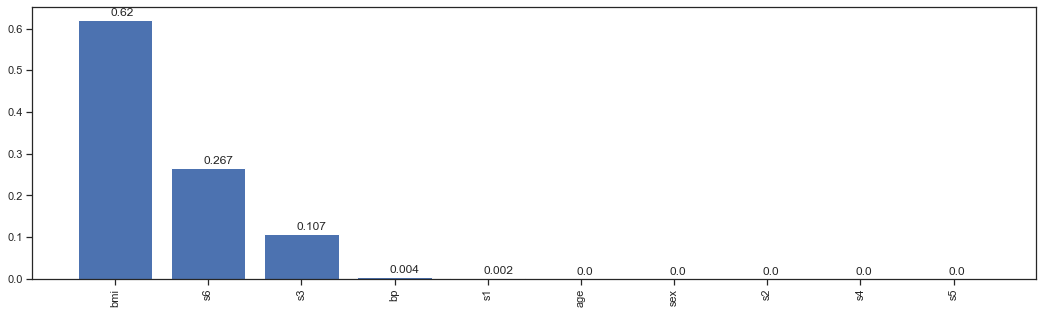

(['bmi', 's6', 's3', 'bp', 's1', 'age', 'sex', 's2', 's4', 's5'],
 [0.6203009857476188,
  0.26674500720037125,
  0.10686039054222239,
  0.003970264146044478,
  0.0021233523637430645,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [45]:
draw_feature_importances(dtr, df_diabetes)

In [46]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

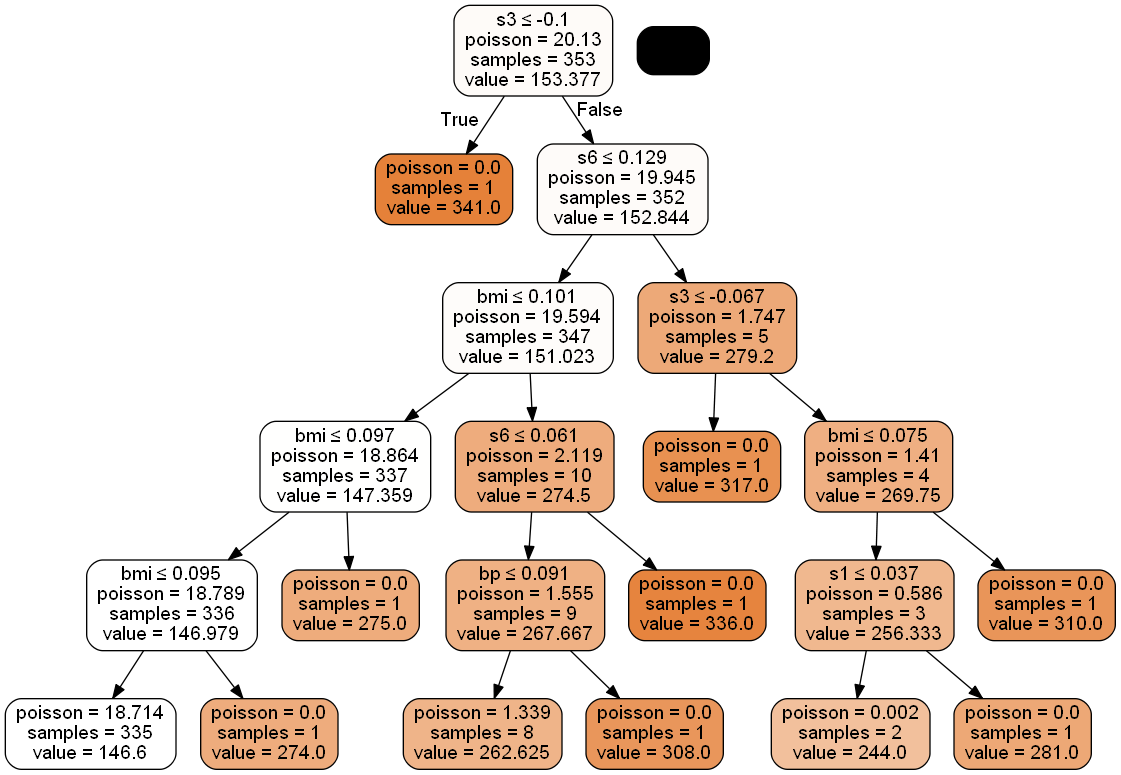

In [47]:
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus

def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

Image(get_png_tree(dtr, df_diabetes[diabetes['feature_names']].columns), height='70%')